In [ ]:
from pathlib import Path

from gdrive_fsspec import GoogleDriveFileSystem
import numpy as np
import pandas as pd
import duckdb
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter, MaxNLocator

cache_dir = Path(".cache")
cache_dir.mkdir(exist_ok=True)

conn = duckdb.connect()

# Real-word dataset

- [Google Drive with real-world data](https://drive.google.com/drive/u/3/folders/1voPQLOcWrLLdxL1gv9rSVn3rWlKz0G_y)


**Input data columns description**

- `#` index (drop)
- `date(ro.created)` - date of report order
- `business_id` - static business id (drop)
- `multi_store_id` - parent store hierarchy
- `store_id` - store id
- `town` - town might have multiple stores
- `county` - static, only one value
- `postcode`
- `product_id` - what does product id of zero mean, unallocated items
- `comment` - i think it's a item name + variant (CHANGE)
- `sku` - should be correlated to product_id? check. need casting to `sku::text` (drop)
- `variation` - always empty (drop)
- `category` - breadcrumb navigation hierarchy (needs cleaning)
- `brand` 630 distinct brands
- `promotion_id` it's a promotion identifier. So we can get basic flag like "the promotion was applied"
- `unit_price` - sometimes 0 - what does it mean. Probaly price was entered manually. There is a concept of "price type"
- `ro.nett_amt/ro.qty`
- `ro.discount_amt/ro.qty`
- `sum(ro.qty)` - fractions - weighted pricing type item

In [22]:
# Load data from cache if possible

file_name = "Dataset_CA_P&G_230925.csv"  # ~ 330MB
local_path = cache_dir / file_name

if local_path.exists():
    print("✅ Using cached file")
    raw_df = pd.read_csv(local_path)
else:
    print("⬇️ Downloading from Google Drive...")
    # Open "Datasets_230925" folder as file system
    gfs = GoogleDriveFileSystem(
        token="browser", root_file_id="1voPQLOcWrLLdxL1gv9rSVn3rWlKz0G_y"
    )
    with gfs.open(file_name) as fsrc, open(local_path, "wb") as fdst:
        fdst.write(fsrc.read())
    print("💾 Saved to cache")
    raw_df = pd.read_csv(local_path)

raw_df.head()

✅ Using cached file


/var/folders/t9/hk7ywmq13ml9md9rwm0f83dw0000gn/T/ipykernel_36170/2426331205.py:8: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_df = pd.read_csv(local_path)


,#,date(ro.created),business_id,multi_store_id,store_id,town,county,postcode,country_id,add1,...,comment,sku,variation,category,brand,promotion_id,unit_price,ro.nett_amt/ro.qty,ro.discount_amt/ro.qty,sum(ro.qty)
0,1,2025-09-21,163,239,500,SAINT EUSTACHE,QC,J7P 0T4,38,163 25E AVENUE,...,COUPE DE GRIFFES,NaN,NaN,NaN,NaN,0,10.00,10.00,0.0,2.0
1,2,2025-09-21,163,239,500,SAINT EUSTACHE,QC,J7P 0T4,38,163 25E AVENUE,...,COUOPE DE GRIFFES,NaN,NaN,NaN,NaN,0,10.00,10.00,0.0,1.0
2,3,2025-09-20,163,239,500,SAINT EUSTACHE,QC,J7P 0T4,38,163 25E AVENUE,...,COUPE DE GRIFFES,NaN,NaN,NaN,NaN,0,10.00,10.00,0.0,2.0
3,4,2025-09-19,163,239,500,SAINT EUSTACHE,QC,J7P 0T4,38,163 25E AVENUE,...,COUPE DE GRIFFES,NaN,NaN,NaN,NaN,0,10.00,10.00,0.0,1.0
4,5,2025-09-18,163,239,500,SAINT EUSTACHE,QC,J7P 0T4,38,163 25E AVENUE,...,mangechato,NaN,NaN,NaN,NaN,0,3.29,3.29,0.0,1.0


In [23]:
df = raw_df.copy()

# rename columns
df.rename(
    columns={
        "date(ro.created)": "date",
        "town": "store_town",
        "postcode": "store_postcode",
        "product_id": "item_id",
        "sku": "item_sku",
        "comment": "item_comment",
        "category": "item_category_hierarchy",
        "brand": "item_brand",
        "promotion_id": "item_promotion_id",
        "unit_price": "item_unit_price",
        "ro.nett_amt/ro.qty": "item_unit_net_price",
        "ro.discount_amt/ro.qty": "item_discount_amount",
        "sum(ro.qty)": "demand",
    },
    inplace=True,
)

# filtering
# 1. Drop "unallocated items"
df = df[df["item_id"] != 0]  # exclude item_id = 0

# basic transforms
df["store_town"] = df["store_town"].str.upper()
df["store_postcode"] = df["store_postcode"].str.upper()
df["item_brand"] = df["item_brand"].fillna("N/A")
df["item_promo_applied"] = df["item_promotion_id"] != 0
df["item_category"] = df["item_category_hierarchy"].str.split(">").str[-1].str.strip()
df["item_category"] = df["item_category"].fillna("Unallocated")
df["item_category"] = df["item_category"].str.upper()

# column type casting
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.astype({"item_promo_applied": "int"})

# column drops
df.drop(
    columns=[
        "#",
        "business_id",
        "county",
        "country_id",
        "add1",
        "variation",
        "item_promotion_id",
        "item_comment",
        "item_sku",
        "item_category_hierarchy",
    ],
    inplace=True,
)


print("✅ Data loaded:", df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1507901 entries, 33 to 1519127
Data columns (total 13 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   date                  1507901 non-null  datetime64[ns]
 1   multi_store_id        1507901 non-null  int64         
 2   store_id              1507901 non-null  int64         
 3   store_town            1507901 non-null  object        
 4   store_postcode        1507901 non-null  object        
 5   item_id               1507901 non-null  int64         
 6   item_brand            1507901 non-null  object        
 7   item_unit_price       1507901 non-null  float64       
 8   item_unit_net_price   1507522 non-null  float64       
 9   item_discount_amount  1507555 non-null  float64       
 10  demand                1507901 non-null  float64       
 11  item_promo_applied    1507901 non-null  int64         
 12  item_category         1507901 non-null  object

In [24]:
# how does the data look like
df.head(25)

,date,multi_store_id,store_id,store_town,store_postcode,item_id,item_brand,item_unit_price,item_unit_net_price,item_discount_amount,demand,item_promo_applied,item_category
33,2025-09-13,239,500,SAINT EUSTACHE,J7P 0T4,22602,FAIM MUSEAU,2.99,2.9900,0.0000,1.0,0,NOURRITURE CRUE
34,2025-07-28,239,500,SAINT EUSTACHE,J7P 0T4,22602,FAIM MUSEAU,2.99,2.9900,0.0000,1.0,0,NOURRITURE CRUE
35,2025-08-02,239,500,SAINT EUSTACHE,J7P 0T4,22605,FAIM MUSEAU,38.99,38.9900,0.0000,1.0,0,NOURRITURE CRUE
36,2025-07-14,239,500,SAINT EUSTACHE,J7P 0T4,22605,FAIM MUSEAU,38.99,38.9900,0.0000,3.0,0,NOURRITURE CRUE
37,2025-09-14,239,500,SAINT EUSTACHE,J7P 0T4,22606,FAIM MUSEAU,32.99,32.9900,0.0000,1.0,0,NOURRITURE CRUE
38,2025-08-09,239,500,SAINT EUSTACHE,J7P 0T4,22606,FAIM MUSEAU,32.99,32.9900,0.0000,1.0,0,NOURRITURE CRUE
39,2025-07-24,239,500,SAINT EUSTACHE,J7P 0T4,22606,FAIM MUSEAU,32.99,32.9900,0.0000,1.0,0,NOURRITURE CRUE
40,2025-09-07,239,500,SAINT EUSTACHE,J7P 0T4,22607,FAIM MUSEAU,47.99,47.9900,0.0000,1.0,0,NOURRITURE CRUE
41,2025-07-17,239,500,SAINT EUSTACHE,J7P 0T4,22608,FAIM MUSEAU,38.99,38.9900,0.0000,1.0,0,NOURRITURE CRUE
42,2025-07-07,239,500,SAINT EUSTACHE,J7P 0T4,22609,FAIM MUSEAU,51.99,51.9900,0.0000,1.0,0,NOURRITURE CRUE


## 0. assumptions

- Series grain is `(date, store_id, item_id)`. This row aggregates all transactions that happen that day.
- "Target variable" (to be predicted) is `demand` (number of items unit sold in particular store in particular date).
- The exercies goal is to forecast daily `demand`
- Promotional and non-promotional sales data is aggregated into single row. 
    - `item_unit_price` reflects the average selling price (volume weighted mean).
    - `item_discount_amount` is the total number of given discount (volume-weighted mean or total).
    - `item_unit_net_price` is the net price per unit sold _without_ discount modifications (volume-weighted mean)
    - Item pricing `item_unit_price` is expected to be equal to `item_unit_net_price - item_discount_amount`. Otherwise there is a pricing mismatch. Use this for quality assesment.
    - Only one pricing column is fed to the final dataset (`item_unit_net_price`?)
- "Active window" (per store, item) is the contiguous period(s) when that item was present/listed/tradable at that store.
- The dataset should not contain the data for pre-listing and post-listing (outside active window). Setting `demand=0` here is conceptually wrong.
- "Intermittency metric" (in-window zero share ratio) - is the fraction of zero sales within active window. Desired value for daily cadence is less than 50%.


**Dataset structure**

- **Series** - `(date, store_id, item_id)`
- **Target** - `demand`
- **Covariates** (extra exploratory variables)
    - **Static features** (series properties)
        - store (with hierarchy): `multi_store_id, store_id, store_town, store_postcode`,
        - item (with hierarchy): `item_id, item_brand, item_category`
    - **Dynamic known features** (changing over time, can be known in advance) - `item_promo_applied, item_unit_net_price`

## 1. sanity

### 1.1 no duplicated series data ❌

In [25]:
# Is the key (data x store_id z item_id) unique? No
conn.execute("""
select 
  cast(date as date) as d, store_id, item_id, count(*) as n_rows
from df
group by 1,2,3
having count(*) > 1
""").df()

,d,store_id,item_id,n_rows
0,2025-08-09,500,31809,3
1,2025-07-17,484,104312,2
2,2025-02-28,478,26720,2
3,2025-03-04,478,28071,2
4,2025-07-30,478,30676,3
...,...,...,...,...
741,2025-02-28,385,390178,3
742,2025-03-14,277,159607,2
743,2024-12-14,276,28520,2
744,2024-09-25,276,28520,2


In [26]:
# Lookup particular non-unique key
conn.execute("""
select * from df
where store_id = 341 and item_id = 26064 and date = date('2025-08-28')
""").df()

,date,multi_store_id,store_id,store_town,store_postcode,item_id,item_brand,item_unit_price,item_unit_net_price,item_discount_amount,demand,item_promo_applied,item_category
0,2025-08-28,335,341,SAINT JEROME,J7Y 1S1,26064,BOREAL,2.29,2.136551,0.15,1.0,0,NOURRITURE HUMIDE
1,2025-08-28,335,341,SAINT JEROME,J7Y 1S1,26064,BOREAL,0.00,NaN,NaN,0.0,0,NOURRITURE HUMIDE


### 1.2 no negative demand, discounts? ❌
Fractional demand exists and it is not a bug in data.

In [27]:
# Are there negative or fractional units?
conn.execute("""
select
  sum(case when demand < 0 then 1 else 0 end) as neg_units,
  sum(case when item_discount_amount < 0 then 1 else 0 end) as negative_discount_rows,
  avg((demand != round(demand))::int)::double as frac_non_integer_share
from df
""").df()

,neg_units,negative_discount_rows,frac_non_integer_share
0,55.0,2672.0,0.000011


### 1.3 promos with no discounts ❌
there are some rows marked as promomotions but no discount was given

In [ ]:
conn.execute("""
select * from df
where item_promo_applied = 1 and item_discount_amount = 0
limit 10
""").df()

,date,multi_store_id,store_id,store_town,store_postcode,item_id,item_brand,item_unit_price,item_unit_net_price,item_discount_amount,demand,item_promo_applied,item_category
0,2025-08-28,239,500,SAINT EUSTACHE,J7P 0T4,22795,BIG COUNTRY RAW,16.99,16.99,0.0,1.0,1,NOURRITURE CRUE
1,2025-08-24,239,500,SAINT EUSTACHE,J7P 0T4,22797,BIG COUNTRY RAW,0.00,0.00,0.0,1.0,1,NOURRITURE CRUE
2,2025-08-31,239,500,SAINT EUSTACHE,J7P 0T4,22898,CHEF CANIN,24.99,24.99,0.0,1.0,1,NOURRITURE CRUE
3,2025-09-07,239,500,SAINT EUSTACHE,J7P 0T4,22900,CHEF CANIN,35.99,35.99,0.0,1.0,1,NOURRITURE CRUE
4,2025-07-23,239,500,SAINT EUSTACHE,J7P 0T4,22938,BOLD BY NATURE,21.99,21.99,0.0,1.0,1,NOURRITURE CRUE
5,2025-08-21,239,500,SAINT EUSTACHE,J7P 0T4,22962,BOLD BY NATURE,15.49,15.49,0.0,1.0,1,NOURRITURE CRUE
6,2025-08-06,239,500,SAINT EUSTACHE,J7P 0T4,22962,BOLD BY NATURE,15.49,15.49,0.0,1.0,1,NOURRITURE CRUE
7,2025-09-05,239,500,SAINT EUSTACHE,J7P 0T4,22965,BOLD BY NATURE,15.69,15.69,0.0,1.0,1,NOURRITURE CRUE
8,2025-07-27,239,500,SAINT EUSTACHE,J7P 0T4,23155,ORIJEN,39.99,39.99,0.0,1.0,1,NOURRITURE SÈCHE
9,2025-08-12,239,500,SAINT EUSTACHE,J7P 0T4,23182,ACANA,29.99,29.99,0.0,1.0,1,NOURRITURE LYOPHILISÉE


### 1.4 pricing identity ❌
(item_unit_price - item_discount_amount ≈ item_unit_net_price) equation does not match. Certain stores are affected more by this.


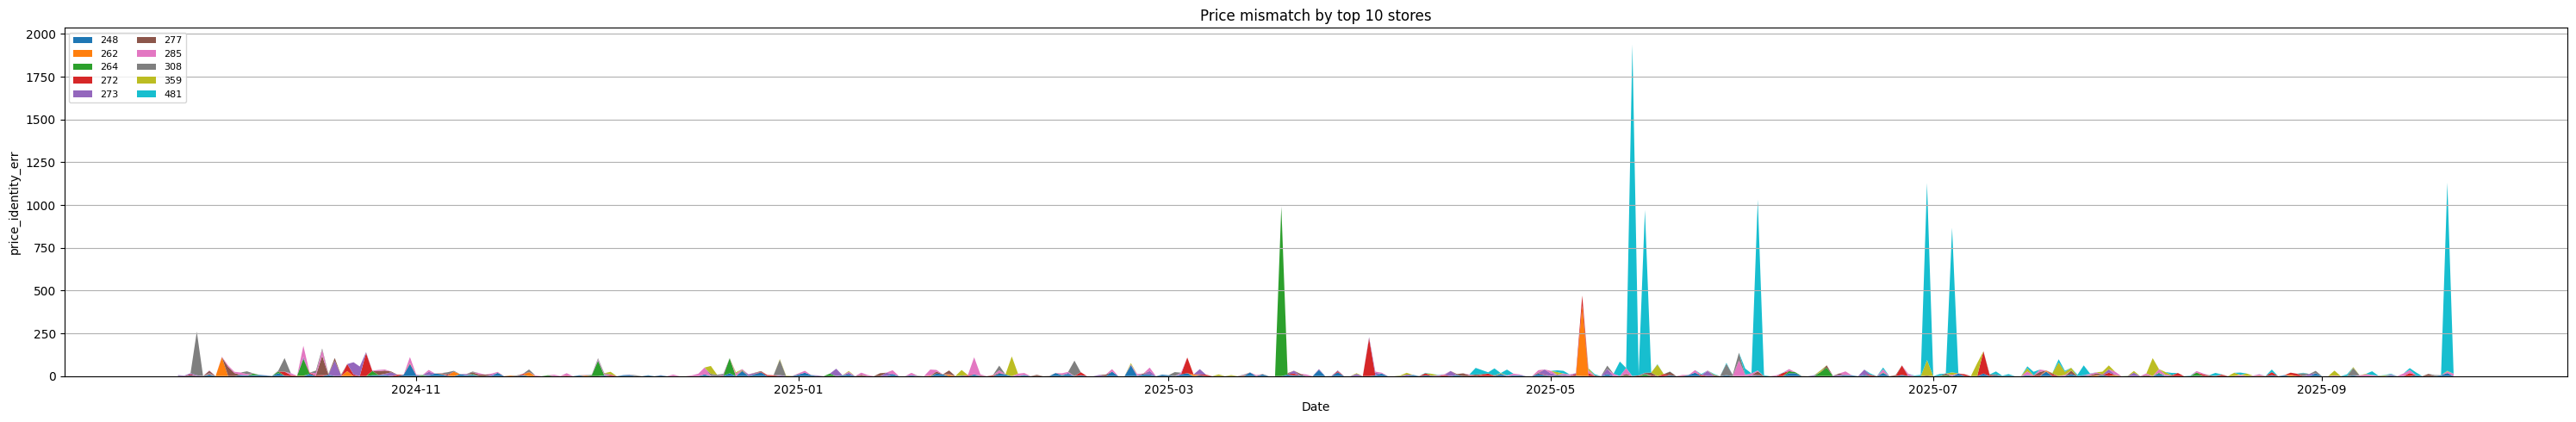

In [28]:
price_err_df = conn.execute("""
select
    date,
    store_id,
    sum(abs(item_unit_price - item_unit_net_price - item_discount_amount)) as price_identity_err
from df
group by 1, 2
""").df()

top_n = 10
top_stores = (
    price_err_df.groupby("store_id")["price_identity_err"]
    .sum()
    .sort_values(ascending=False)
    .head(top_n)
    .index
)

wide = (
    price_err_df[price_err_df["store_id"].isin(top_stores)]
    .pivot_table(
        index="date", columns="store_id", values="price_identity_err", aggfunc="sum"
    )
    .fillna(0)
    .sort_index()
)

fig, ax = plt.subplots(figsize=(30, 5))
ax.stackplot(wide.index, wide.T.values, labels=wide.columns)
ax.set_title(f"Price mismatch by top {top_n} stores")
ax.set_xlabel("Date")
ax.set_ylabel("price_identity_err")
# ax.set_yscale('log')
ax.legend(loc="upper left", ncol=2, fontsize=8)
ax.grid(True, axis="y")
plt.tight_layout()
plt.show()

### 1.5 price consistency check
This check looks for **inconsistent pricing** for the same item in the same store on the same day. If the price swings a lot within that day, we flag it as “wild price variance.”

**Why it matters**
- Forecast models assume price is consistent for a given day. If one item has multiple different prices on the same day, the model “thinks” price changes caused demand changes that never really happened.
- Noisy line-level prices usually come from data capture quirks (e.g., per-line discounts, rounding, returns) and can distort promo uplift, elasticities, and demand predictions.
- If this is systemic, we should **aggregate to a clean daily price** (e.g., volume-weighted net price) before modeling.

**How the query works**
- For each `(date, store_id, item_id)`, we compute a **net unit price** (list price minus discount, or provided net).
- We then summarize all rows for that day/store/item:
    - `n_rows`: how many transaction lines exist that day for that item.
    - `min_price` / `max_price` / `avg_price` / `med_price` (median) and `sd_price` (std dev).
    - `rel_range_vs_med`: `(max − min) / median` → percent spread around the typical price.
    - `cv_price`: `std dev / mean` → relative volatility.
- We **flag** groups with multiple rows and a large spread (e.g., >20% around the median or high coefficient of variation).

In [74]:
noise_df = conn.execute("""
with base as (
  select
    cast(date as date) as d,
    store_id,
    item_id,
    coalesce(item_unit_net_price, item_unit_price - coalesce(item_discount_amount, 0))::double as net_price,
    demand::double as qty
  from df
),
g as (
  select
    d, store_id, item_id,
    count(*)                                   as n_rows,
    sum(qty)                                   as total_qty,
    avg(net_price)                             as avg_price,
    median(net_price)                          as med_price,
    min(net_price)                             as min_price,
    max(net_price)                             as max_price,
    stddev_pop(net_price)                      as sd_price,
    (max(net_price) - min(net_price))          as abs_range,
    (max(net_price) - min(net_price)) / nullif(median(net_price),0) as rel_range_vs_med,
    stddev_pop(net_price) / nullif(avg(net_price),0)                as cv_price
  from base
  group by 1,2,3
)
select
  d, store_id, item_id,
  n_rows, total_qty,
  min_price, max_price, avg_price, med_price,
  sd_price, abs_range,
  rel_range_vs_med,
  cv_price                    -- coefficient of variation
from g
where
  n_rows > 1                            -- multiple rows => potential transaction noise
  and (
        rel_range_vs_med > 0.20         -- >20% spread within the day
        or cv_price > 0.10              -- >10% CV as a backup criterion
      )
order by rel_range_vs_med desc, cv_price desc
""").df()

noise_df.head(10)

,d,store_id,item_id,n_rows,total_qty,min_price,max_price,avg_price,med_price,sd_price,abs_range,rel_range_vs_med,cv_price
0,2025-08-28,478,300290,3,18.0,0.300000,25.890000,8.860000,0.390000,12.042085,25.590000,65.615385,1.359152
1,2025-05-06,454,41371,3,3.0,4.490000,129.990000,46.390000,4.690000,59.114183,125.500000,26.759062,1.274287
2,2025-08-02,454,402790,3,3.0,0.750000,59.990000,21.076667,2.490000,27.525050,59.240000,23.791165,1.305949
3,2025-07-15,385,367789,3,5.0,2.690000,94.990000,34.806667,6.740000,42.588150,92.300000,13.694362,1.223563
4,2025-09-08,478,30838,3,3.0,9.990000,105.000000,41.663333,10.000000,44.785787,95.010000,9.501000,1.074945
5,2025-07-27,500,24337,3,3.0,0.990000,36.990000,13.993333,4.000000,16.307463,36.000000,9.000000,1.165374
6,2025-07-27,500,370544,3,3.0,-25.000000,7.990000,-4.340000,3.990000,14.699812,32.990000,8.268170,-3.387053
7,2025-08-19,473,488774,3,3.0,6.000000,100.000000,39.663333,12.990000,42.759794,94.000000,7.236336,1.078069
8,2025-04-01,473,394481,3,3.0,5.000000,60.000000,25.330000,10.990000,24.637055,55.000000,5.004550,0.972643
9,2025-05-30,478,390382,7,9.0,0.920019,12.792258,4.845812,2.392049,4.180672,11.872239,4.963210,0.862739


**How to read the results**

Each row is a **flagged case** (a day/store/item combo). Focus on:

- `rel_range_vs_med`
    - `~0.05–0.10` → small, likely fine
    - `~0.10–0.20` → moderate, review
    - `0.20` → large inconsistency worth action

- `cv_price` (coefficient of variation)
    - `0.10` suggests meaningful volatility even if min–max is driven by a few lines
- `n_rows` and `total_qty`
    - If `n_rows` is high and `total_qty` is meaningful, the inconsistency is **systemic**, not a one-off line error.

**Typical causes**
- Line-level vs. basket-level discounts recorded differently.
- Mixed units (e.g., different pack sizes mapped under one item).
- Returns/refunds posted as negative lines affecting average line price.
- Timing issues (mid-day price change, but transactions overlap the change).
- Rounding/measurement quirks for weight-based items.

**What can be done**
- Standardize net price logic (prefer a reliable net price field; otherwise compute list − discount).
- Aggregate to daily before modeling: use volume-weighted net price (example below).
- Quarantine extreme outliers (e.g., >80% discount or near-zero/negative prices) for data quality review.

**Volume-weighted net price example** 
```
Same store, same item, same day:

- 09:15 — sold 100 units at €10.00
- 15:30 — promo starts; sold 50 units at €9.00
- Total demand = 100 + 50 = 150 units
- Weighted net price = (100×10 + 50×9) / 150 = (1000 + 450) / 150 = €9.67
```

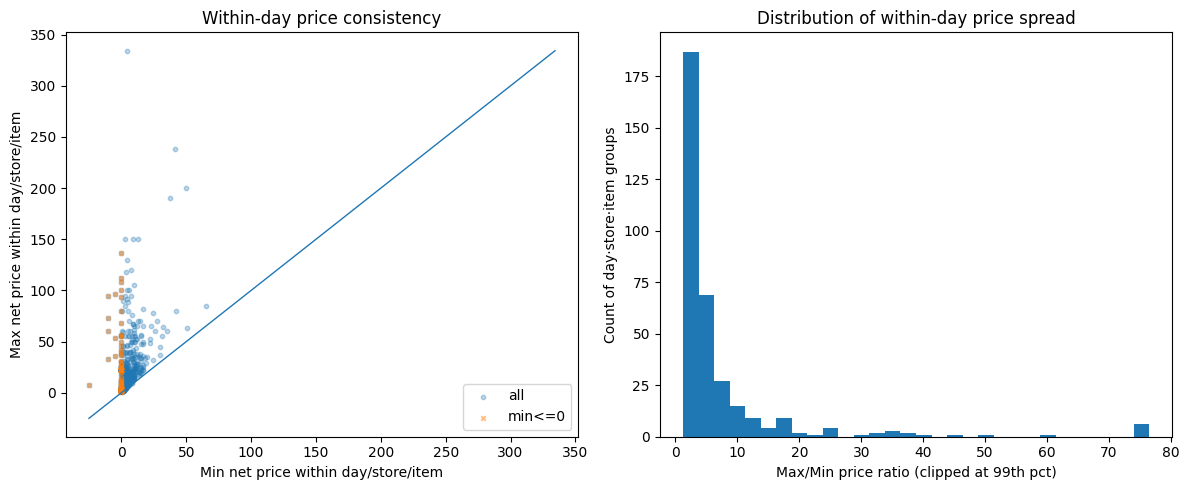

In [ ]:
# --- prepare columns ---
noise_df["range_ratio"] = np.where(
    noise_df["min_price"] <= 0, np.nan, noise_df["max_price"] / noise_df["min_price"]
)
noise_df["is_neg_or_zero_min"] = (noise_df["min_price"] <= 0).astype(int)

# --- clip extreme ratios for readable histogram axes ---
ratio_clip = noise_df["range_ratio"].quantile(0.99)
noise_df["range_ratio_clipped"] = noise_df["range_ratio"].clip(upper=ratio_clip)

# --- create one figure, two subplots (1 row × 2 columns) ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ===== LEFT subplot: scatter (min vs max) =====
ax = axes[0]
ax.scatter(noise_df["min_price"], noise_df["max_price"], alpha=0.3, s=10, label="all")

# highlight suspicious (min <= 0)
sus = noise_df["is_neg_or_zero_min"] == 1
if sus.any():
    ax.scatter(
        noise_df.loc[sus, "min_price"],
        noise_df.loc[sus, "max_price"],
        alpha=0.5,
        s=10,
        marker="x",
        label="min<=0",
    )

# y = x guideline
lims = [
    np.nanmin([noise_df["min_price"].min(), noise_df["max_price"].min()]),
    np.nanmax([noise_df["min_price"].max(), noise_df["max_price"].max()]),
]
ax.plot(lims, lims, linewidth=1)
ax.set_xlabel("Min net price within day/store/item")
ax.set_ylabel("Max net price within day/store/item")
ax.set_title("Within-day price consistency")
ax.legend()

# ===== RIGHT subplot: histogram of ratio =====
ax = axes[1]
valid = noise_df["range_ratio_clipped"].dropna()
ax.hist(valid, bins=30)
ax.set_xlabel("Max/Min price ratio (clipped at 99th pct)")
ax.set_ylabel("Count of day·store·item groups")
ax.set_title("Distribution of within-day price spread")

plt.tight_layout()
plt.show()

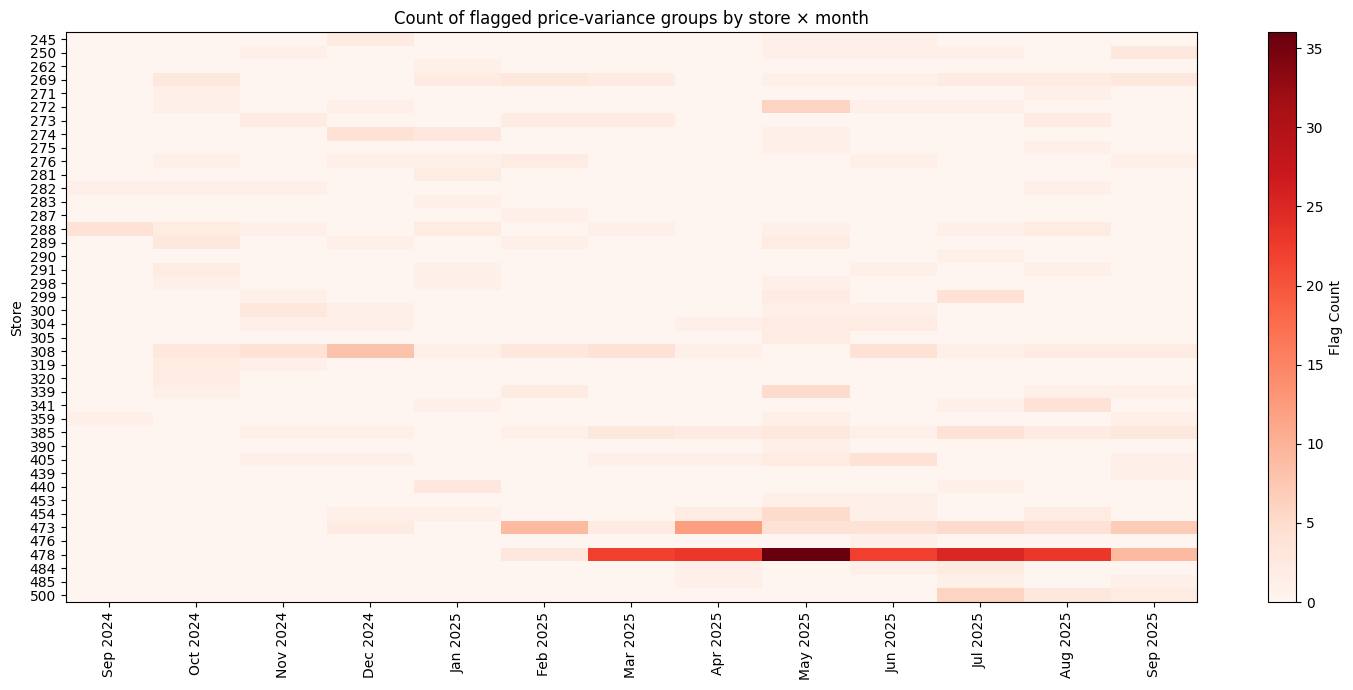

In [ ]:
noise_df["month"] = pd.to_datetime(noise_df["d"]).dt.to_period("M").astype(str)

pivot = noise_df.assign(flag=1).pivot_table(
    index="store_id", columns="month", values="flag", aggfunc="sum", fill_value=0
)

# Convert the pivot columns (YYYY-MM) into prettier month names
month_labels = [pd.Period(m).strftime("%b %Y") for m in pivot.columns]

plt.figure(figsize=(15, 7))
plt.imshow(
    pivot.values,
    aspect="auto",
    cmap="Reds",  # red = bad, white = good
    interpolation="nearest",
    vmin=0,
)
plt.xticks(ticks=np.arange(len(pivot.columns)), labels=month_labels, rotation=90)
plt.yticks(ticks=np.arange(len(pivot.index)), labels=pivot.index)
plt.ylabel("Store")
plt.title("Count of flagged price-variance groups by store × month")
plt.colorbar(label="Flagged Count")
plt.tight_layout()
plt.show()

## 2. store coverage

### 2.1 missing vs zero
Visualize how many store has missing sales data on certain day. Notice that there are around 10 stores that consistently does not report any data. Maybe those can be filtered out...

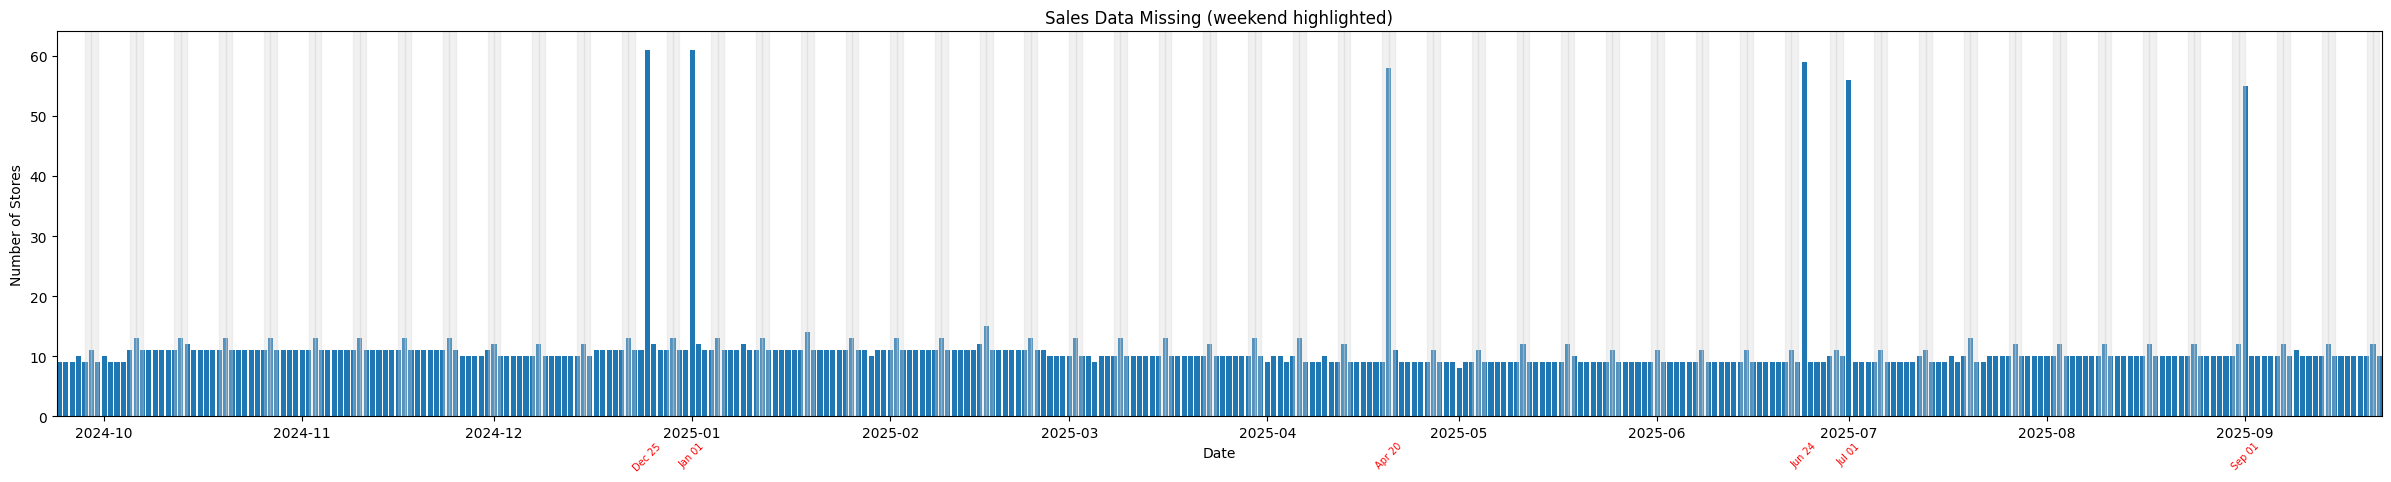

In [29]:
store_coverage_df = conn.execute("""
with
date_spine as (
    select * 
    from generate_series(
        (select min(date) from df),
        (select max(date) from df),
        interval 1 day
    ) as g(d),
),

store_spine as (
    select distinct store_id from df
),

full_store_calendar as (
    select ds.d, ss.store_id
    from date_spine ds
    cross join store_spine ss
),

store_days as (
    select
        date as d,
        store_id,
        1 as has_row
    from df
    group by 1, 2
),

store_coverage as (
    select
        fsc.d,
        fsc.store_id,
        coalesce(sd.has_row,0) as has_row
    from full_store_calendar fsc
    left join store_days sd using(d, store_id)
)

select
  d,
  sum(has_row) as active_stores,
  count(*) - sum(has_row) as missing_store_days
from store_coverage
group by 1
order by 1
""").df()

# Ploting
fig, ax = plt.subplots(figsize=(30, 5))
ax.bar(
    store_coverage_df["d"],
    store_coverage_df["missing_store_days"],
)
# Highlight weekends
for date in store_coverage_df["d"]:
    if date.weekday() >= 5:  # 5 = Saturday, 6 = Sunday
        ax.axvspan(date, date + pd.Timedelta(days=1), color="lightgray", alpha=0.3)

# Highlight days when missing_store_days exceeds threshold
threshold = 30
above = store_coverage_df[store_coverage_df["missing_store_days"] > threshold]

for _, row in above.iterrows():
    ax.text(
        row["d"],
        -4,  # slightly below axis
        row["d"].strftime("%b %d"),
        rotation=45,
        color="red",
        ha="center",
        va="top",
        fontsize=7,
    )

ax.set_title("Sales Data Missing (weekend highlighted)")
ax.set_xlabel("Date")
ax.set_ylabel("Number of Stores")
plt.margins(x=0)
plt.show()

## 3. item lifecycle

### 3.1 average number of items per store

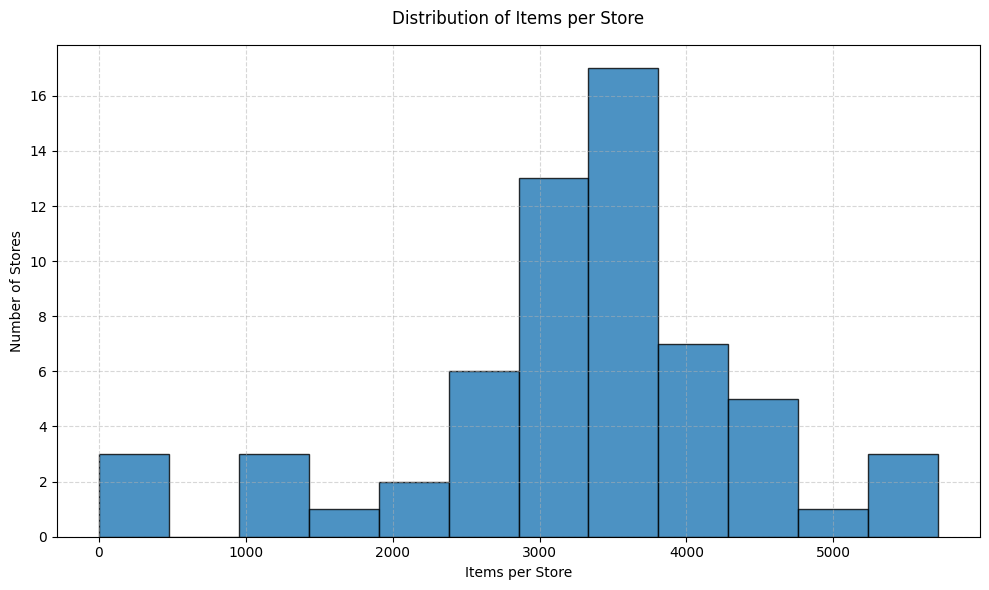

In [30]:
all_store_items_df = conn.execute("""
select
    store_id,
    count(distinct item_id) as items_per_store
from df
group by 1
""").df()

# plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(all_store_items_df["items_per_store"], bins=12, edgecolor="black", alpha=0.8)
ax.set_title("Distribution of Items per Store", pad=15)
ax.set_xlabel("Items per Store")
ax.set_ylabel("Number of Stores")
ax.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

### 3.2 item lifespan

- how long a store–item “exists” in the data (lifespan)
- how often it shows up during that existence (activity rate / coverage)

> high lifespan, low coverage: its' likely that zero-demand days are not stored explicitly
>
> short lifespans: this is a cold start problem, maybe consider forecasting for categories or use simple models as a baseline
>
> desired coverage should be around 80%, when values are lower consider (1) weekly aggregation (2) other hierarchy features

In [31]:
intermittency_df = conn.execute("""
with

daily as (
  select
    cast(date as date) as d, store_id, item_id
  from df
  group by 1,2,3
),

active_windows as (
  select
    store_id,
    item_id,
    min(d) as first_seen,
    max(d) as last_seen,
    count(*) as n_days_with_sales,
    datediff('day', min(d), max(d)) + 1 as lifespan_days
  from daily
  group by 1,2
),

final as (
    select
      concat(store_id, '_', item_id) as window_id,
      lifespan_days,
      n_days_with_sales,
      n_days_with_sales / lifespan_days as activity_rate
    from active_windows
)

select * from final
""").df()

intermittency_df

,window_id,lifespan_days,n_days_with_sales,activity_rate
0,454_42357,358,29,0.081006
1,453_23563,124,2,0.016129
2,453_23660,1,1,1.000000
3,453_24841,1,1,1.000000
4,453_24869,166,4,0.024096
...,...,...,...,...
198969,306_23199,1,1,1.000000
198970,306_237862,1,1,1.000000
198971,264_234433,1,1,1.000000
198972,263_29798,1,1,1.000000


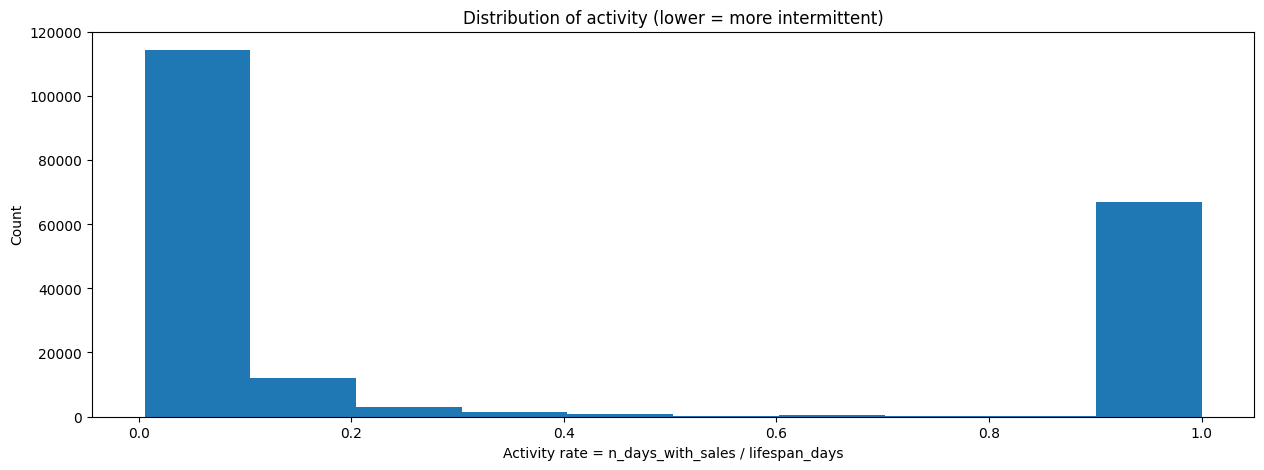

In [32]:
plt.figure(figsize=(15, 5))
plt.hist(intermittency_df["activity_rate"].dropna())
plt.xlabel("Activity rate = n_days_with_sales / lifespan_days")
plt.ylabel("Count")
plt.title("Distribution of activity (lower = more intermittent)")
plt.show()

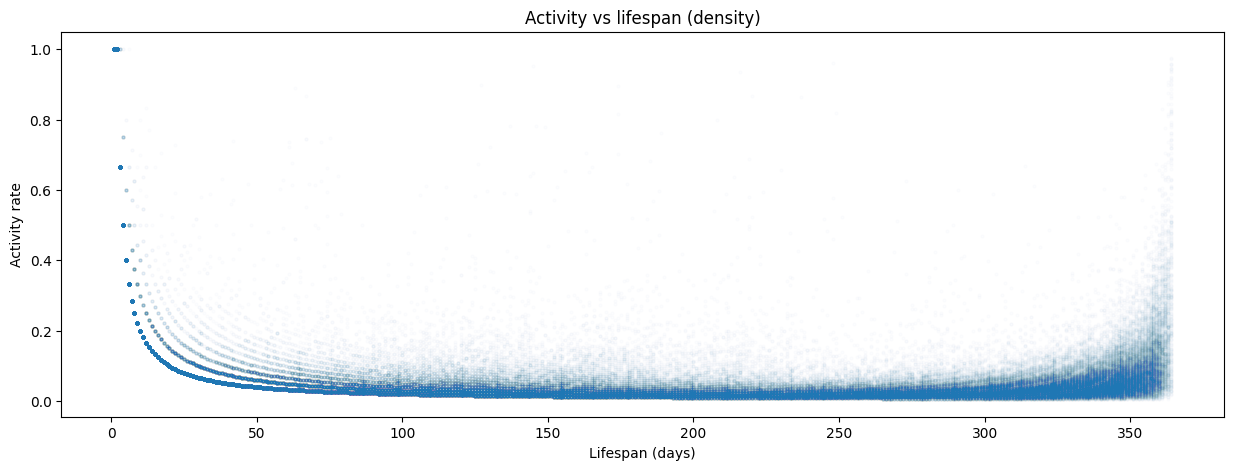

In [33]:
plt.figure(figsize=(15, 5))
plt.scatter(
    intermittency_df["lifespan_days"],
    intermittency_df["activity_rate"],
    s=5,
    alpha=0.01,
)
plt.xlabel("Lifespan (days)")
plt.ylabel("Activity rate")
plt.title("Activity vs lifespan (density)")
plt.show()

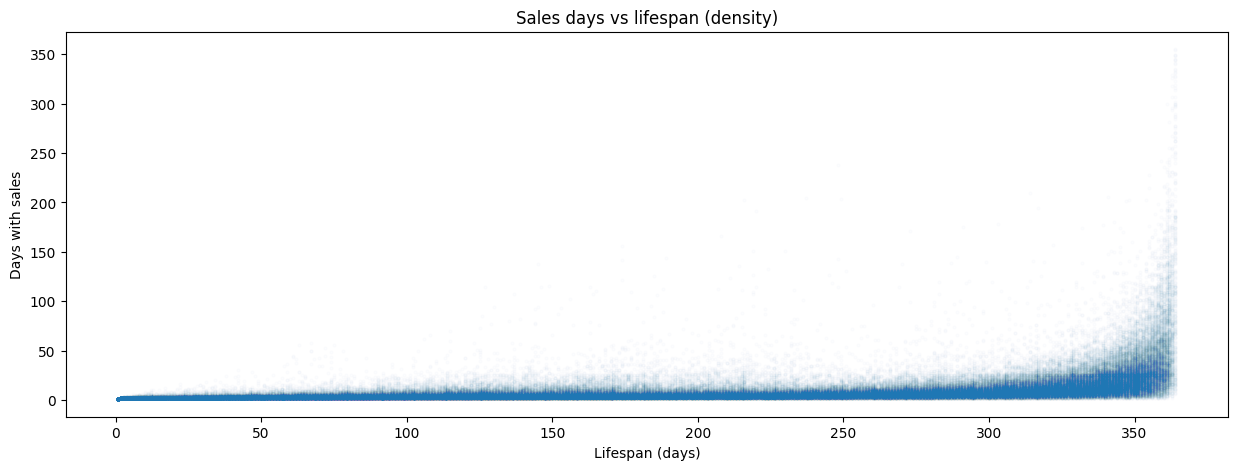

In [34]:
plt.figure(figsize=(15, 5))
plt.scatter(
    intermittency_df["lifespan_days"],
    intermittency_df["n_days_with_sales"],
    s=5,
    alpha=0.01,
)
plt.xlabel("Lifespan (days)")
plt.ylabel("Days with sales")
plt.title("Sales days vs lifespan (density)")
plt.show()


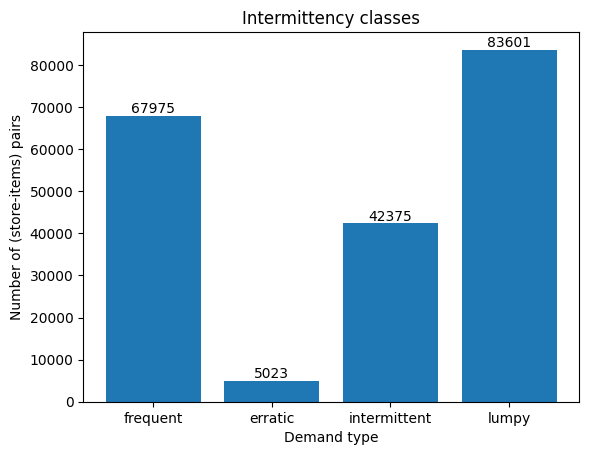

In [35]:
def classify(a):
    if a >= 0.5:
        return "frequent"
    if a >= 0.2:
        return "erratic"
    if a >= 0.05:
        return "intermittent"
    return "lumpy"


intermittency_df["demand_type"] = intermittency_df["activity_rate"].map(classify)
counts = (
    intermittency_df["demand_type"]
    .value_counts()
    .reindex(["frequent", "erratic", "intermittent", "lumpy"], fill_value=0)
)

plt.figure()
plt.bar(counts.index, counts.values)
plt.xlabel("Demand type")
plt.ylabel("Number of (store-items) pairs")
plt.title("Intermittency classes")
for i, v in enumerate(counts.values):
    plt.text(i, v, str(v), ha="center", va="bottom", rotation=0)
plt.show()


In [36]:
lifecycle_avg = intermittency_df["lifespan_days"].mean()
days_with_sales_avg = intermittency_df["n_days_with_sales"].mean()
activity_rate_avg = intermittency_df["activity_rate"].mean()

print(f"""
A typical store-item lives {round(lifecycle_avg)} days.
It appears on {round(days_with_sales_avg, 1)} days within this span.
Average coverage is {round(activity_rate_avg, 2)}.
""")



A typical store-item lives 133 days.
It appears on 7.6 days within this span.
Average coverage is 0.38.



In [37]:
# sanity check
diff = (days_with_sales_avg / lifecycle_avg) - activity_rate_avg  # should be zero

if abs(diff) > 0.1:
    print(
        f"Data coverage inconsistency (diff: {round(diff, 2)}). Probable data mismatch. Check for data duplicates!"
    )

Data coverage inconsistency (diff: -0.32). Probable data mismatch. Check for data duplicates!


Majority of the data falls as "intermittent" or "lumpy". Plainly speaking they are sold very rarely when listed (low activity rate).

Some ideas:
- Consider weekly aggregation for heavy zero-inflation (instead of daily).
- Croston/SBA/ADIDA methods. Classic ways to forecast intermittent demand (lots of zeros with occasional non-zero spikes).

## --- WIP BELOW --- ## 

## 4. seasonality & calendar effects

In [ ]:
import holidays
from datetime import timedelta

calendar_df = conn.execute("""
select
  date,
  sum(demand) as sum_demand,
  count(*) as total_rows
from df
group by 1
order by 1;
""").df()

# gb holidays
gb_holidays = holidays.GB(years=sorted(calendar_df["date"].dt.year.unique()))


# --- near_payday ---
# Define "near payday" as within ±3 days of either the 25th or the LAST UK business day of the month.
# Last business day excludes weekends and UK bank holidays.
def last_business_day(ts: pd.Timestamp) -> pd.Timestamp:
    # end of the month (calendar)
    eom = (ts + pd.offsets.MonthEnd(0)).normalize()
    d = eom
    while d.weekday() >= 5 or d in gb_holidays:  # weekend or bank holiday
        d -= timedelta(days=1)
    return d


def is_near_payday(ts: pd.Timestamp) -> bool:
    d25 = pd.Timestamp(year=ts.year, month=ts.month, day=25)
    # If 25th is outside the dataset's timezone normalization, just compare by date
    lbd = last_business_day(ts)
    # distance to either target in days
    dist_25 = abs((ts.normalize() - d25.normalize()).days)
    dist_lbd = abs((ts.normalize() - lbd.normalize()).days)
    return (dist_25 <= 3) or (dist_lbd <= 3)


# add basic calendar features
calendar_df["dow"] = calendar_df["date"].dt.weekday  # 0=Mon ... 6=Sun
calendar_df["is_weekend"] = calendar_df["dow"] >= 5
calendar_df["month"] = calendar_df["date"].dt.month
calendar_df["week_of_year"] = calendar_df["date"].dt.isocalendar().week.astype(int)
calendar_df["is_month_end"] = calendar_df["date"].dt.is_month_end
calendar_df["is_holiday"] = (
    calendar_df["date"].dt.normalize().isin(pd.to_datetime(list(gb_holidays.keys())))
)
calendar_df["near_payday"] = calendar_df["date"].apply(is_near_payday)

calendar_df


,date,sum_demand,total_rows,dow,is_weekend,month,week_of_year,is_month_end,is_holiday,near_payday
0,2024-09-24,6147.0,3820,1,False,9,39,False,False,True
1,2024-09-25,4730.0,2818,2,False,9,39,False,False,True
2,2024-09-26,7368.0,4307,3,False,9,39,False,False,True
3,2024-09-27,8023.0,4646,4,False,9,39,False,False,True
4,2024-09-28,7324.0,4417,5,True,9,39,False,False,True
...,...,...,...,...,...,...,...,...,...,...
357,2025-09-18,7238.0,4448,3,False,9,38,False,False,False
358,2025-09-19,7345.0,4554,4,False,9,38,False,False,False
359,2025-09-20,6612.0,4251,5,True,9,38,False,False,False
360,2025-09-21,6972.0,4360,6,True,9,38,False,False,False


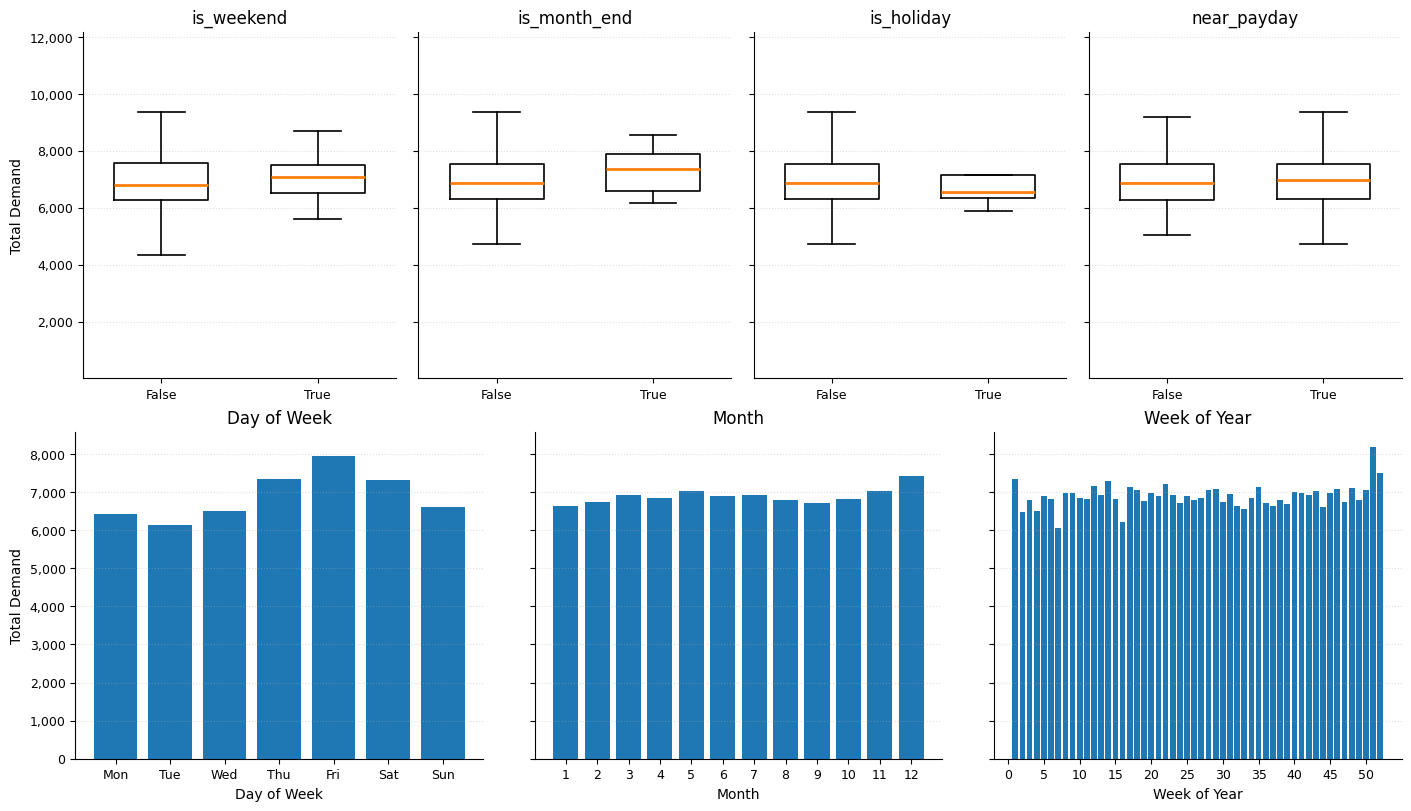

In [ ]:
target_col = "sum_demand"
target_label = "Total Demand"

bool_cols = ["is_weekend", "is_month_end", "is_holiday", "near_payday"]
calendar_df[bool_cols] = calendar_df[bool_cols].astype(int)

# ---- Precompute aggregates ----
dow_means = calendar_df.groupby("dow", sort=True)[target_col].mean()
month_means = calendar_df.groupby("month", sort=True)[target_col].mean()
woy_means = calendar_df.groupby("week_of_year", sort=True)[target_col].mean()

# Common y-range for all plots
yvals = calendar_df[target_col].to_numpy()
ymin, ymax = float(np.nanmin(yvals)), float(np.nanmax(yvals))

fig = plt.figure(figsize=(14, 8), constrained_layout=True)
outer = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[1, 1])

# --- Top row: boxplots
gs_top = outer[0].subgridspec(1, 4, wspace=0.05)
axes_top = gs_top.subplots(sharey=True)

for i, col in enumerate(bool_cols):
    ax = axes_top[i]
    ax.boxplot(
        [
            calendar_df.loc[calendar_df[col] == 0, target_col].values,
            calendar_df.loc[calendar_df[col] == 1, target_col].values,
        ],
        tick_labels=["False", "True"],
        widths=0.6,
        showfliers=False,
        medianprops=dict(linewidth=2),
        boxprops=dict(linewidth=1.2),
        whiskerprops=dict(linewidth=1.2),
        capprops=dict(linewidth=1.2),
    )
    ax.set_title(col)
    if i == 0:
        ax.set_ylabel(target_label)
    ax.set_ylim(ymin, ymax)
    ax.grid(True, axis="y", linestyle=":", alpha=0.4)

# --- Bottom row: bars
gs_bottom = outer[1].subgridspec(1, 3, wspace=0.1)
axes_bottom = gs_bottom.subplots(sharey=True)

# Day of Week
axes_bottom[0].bar(dow_means.index, dow_means.values)
axes_bottom[0].set_title("Day of Week")
axes_bottom[0].set_xlabel("Day of Week")
axes_bottom[0].set_ylabel(target_label)
axes_bottom[0].set_xticks(range(7))
axes_bottom[0].set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
axes_bottom[0].grid(True, axis="y", linestyle=":", alpha=0.4)

# Month
axes_bottom[1].bar(month_means.index, month_means.values)
axes_bottom[1].set_title("Month")
axes_bottom[1].set_xlabel("Month")
axes_bottom[1].set_xticks(range(1, 13))
axes_bottom[1].grid(True, axis="y", linestyle=":", alpha=0.4)

# Week of Year
axes_bottom[2].bar(woy_means.index, woy_means.values)
axes_bottom[2].set_title("Week of Year")
axes_bottom[2].set_xlabel("Week of Year")
axes_bottom[2].xaxis.set_major_locator(MaxNLocator(nbins=13, integer=True))
axes_bottom[2].grid(True, axis="y", linestyle=":", alpha=0.4)

for ax in fig.axes:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
    ax.tick_params(labelsize=9)

plt.show()

## 5. intermittent demand & long tail

In [42]:
conn.execute("""
select item_id, count(distinct store_id) from df group by 1
""").df()


,item_id,count(DISTINCT store_id)
0,38507,18
1,40137,12
2,40331,32
3,41239,35
4,41438,19
...,...,...
20234,37135,1
20235,37145,1
20236,37190,1
20237,37381,1


### Stores

- number of stores, numer of multistores in time
- how many stores each multistore has
- sales per multistore, sales per store


In [43]:
%%sql eda_stores_df <<

with stores as (
    select
        date,
        count(distinct store_id) as stores,
        count(distinct multi_store_id) as multi_stores
    from df
    group by date
)
select
    d.d as date,
    s.stores as stores,
    s.multi_stores as multi_stores
from date_spine_df d
left join stores s on (s.date = d.d)
order by d.d

UsageError: Cell magic `%%sql` not found.


## Others
- Cold-start series problem (<90 days of history)
- Item, store hierarchy

## Conclusions
- Instead of predicting (store, item), we might try to predict (store, category)